## 두칸짜리 그리드 월드의 반복적 정책 평가 알고리즘

In [2]:
V = {'L1':0, 'L2':0}
cnt = 0
while True:
    t = 0.5 * (-1 + 0.9 * V['L1']) + 0.5 * (1 + 0.9 * V['L2']) # 첫 상태 공간의 가치함수
    delta = abs(t - V['L1']) # 첫 상태 공간의 가치함수 갱신값
    V['L1'] = t
    
    t = 0.5 * (0 + 0.9 * V['L1']) + 0.5 * (-1 + 0.9 * V['L2']) # 두번째 상태 공간의 가치함수
    delta = max(delta , abs(t - V['L2'])) # 첫 상태 공간의 가치함수 갱신값과 두번째 상태 공간의 갱신값 중 큰값
    V['L2'] = t
    
    cnt += 1
    if delta < 0.0001: # 가치함수 갱신값의 임계값보다 작다면
        print(V)
        print(f'갱신횟수 {cnt}회')
        break

{'L1': -2.2493782177156936, 'L2': -2.7494201578106514}
갱신횟수 60회


## Gridworld 생성
시각화 파일인 gridworld_render.py파일을 가져와서 사용한다. 시각화쪽은 코드가 복잡하여 이미 제작 되어 있는 형태를 사용한다.

In [4]:
import numpy as np
import gridworld_render as render_helper

class GridWorld:
    
    def __init__(self):
        self.action_space = [0, 1, 2, 3] # action index
        
        self.action_meaning = {0:'업', 
                               1:'다운',
                               2:'왼쪽',
                               3:'오른쪽'
        } # name of action
        
        self.reward_map = np.array(
        [[0, 0, 0, 1],
         [0, None, 0, -1],
         [0, 0, 0, 0]]
        ) # reward in space
        
        self.goal_state = (0, 3) # 목표
        self.wall_state = (1, 1) # 벽 좌표
        self.start_state = (2, 0) # 시작 좌표
        self.agent_state = self.start_state # 에이전트 초기 좌표
        
    @property
    def height(self):
        return len(self.reward_map)

    @property
    def width(self):
        return len(self.reward_map[0])

    @property
    def shape(self):
        return self.reward_map.shape
    
    def actions(self):
        return self.action_space
    
    def states(self): # iterable 인스턴스로 생성
        for h in range(self.height):
            for w in range(self.width):
                yield (h, w)
                
    def next_state(self, state, action):
        # 이동위치 계산
        action_move_map = [(-1, 0), (1, 0), (0, -1), (0, 1)] # 업, 다운, 왼쪽, 오른쪽을 행렬 인덱스에서 표현
        move = action_move_map[action] # 액션 인덱스에 따라 움직임 설정
        next_state = (state[0] + move[0], state[1] + move[1])
        ny, nx = next_state
        
        if nx < 0 or nx >= self.width or ny < 0 or ny >= self.height:
            next_state = state
        elif next_state == self.wall_state:
            next_state = state
        
        return next_state
    
    def reward(self, state, action, next_state): # r(s, a, s')
        return self.reward_map[next_state]

    def render_v(self, v=None, policy=None, print_value=True): # V, pi 전달하여 상태공간 시각화 함수
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_v(v, policy, print_value)

    def render_q(self, q=None, print_value=True): # 이번에는 안쓰임
        renderer = render_helper.Renderer(self.reward_map, self.goal_state,
                                          self.wall_state)
        renderer.render_q(q, print_value)

In [18]:
env = GridWorld()

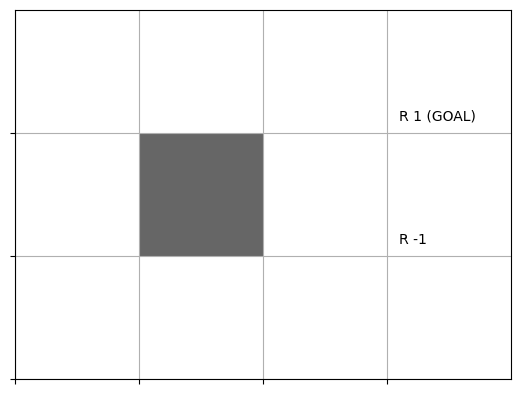

In [22]:

# 시각화 테스트 책에 설명은 없지만 시각화 도구인 gridworld_render.py 파일을 사용합니다.
env.render_v()

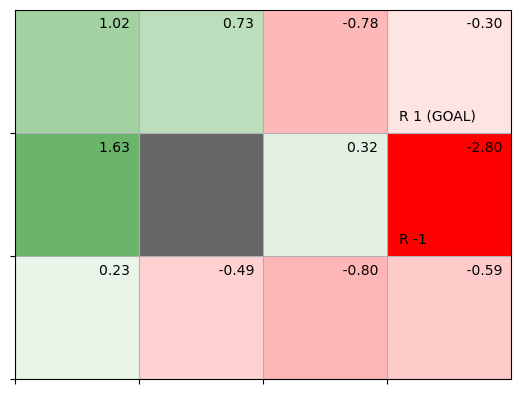

In [24]:
# 각 상태에 무작위 가치를 부여하고 랜더링 (정책이나 움직임 고려 않고 state에 가치 정의 그냥 렌더링 테스트)
V = {}
for state in env.states():
    V[state] = np.random.randn()
env.render_v(V)

## 무작위 정책을 갖는 정책 평가 구현 (다만 정책을 한번만 평가한다.)

In [6]:
from collections import defaultdict
V = defaultdict(lambda: 0)
pi = defaultdict(lambda: {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25}) # 4방향 확률 동등 무작위 선택

In [2]:
# 각 전체상태에 해당하는 가치함수를 한번만 평가
def eval_onestep(pi, V, env, gamma=0.9):
    for state in env.states():
        if state == env.goal_state: # 목표 도달 시의 가치는 0으로 설정
            V[state] = 0
            continue
        
        action_probs = pi[state] # 모든 상태에 따른 액션확률값(정책)을 딕셔너리로 저장
        new_V = 0 # 업데이트 될 상태가치 정의
        
        for action, action_probs in action_probs.items(): # 상태에서 취할 수 있는 모든 액션 순환 하면서 액션과 확률값을 반복자로 사용
            next_state = env.next_state(state, action) # s' 정의 
            r = env.reward(state, action, next_state) # 위에서 정의한 s'이 정의되면 reward 계산가능 r(s, a, s')
            new_V += action_probs * (r + gamma * V[next_state]) # 가치 평가 함수 V = p(s, a){r(s, a, s') + rV(s')
            
        V[state] = new_V # 가치함수 업데이트
    return V

In [8]:
# 위에서 생성한 원스텝 가치평가함수 반복
def policy_eval(pi, V, env, gamma=0.9, threshold=0.001):
    while True:
        old_V = V.copy()
        V = eval_onestep(pi, V, env, gamma)
        
        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t
        if delta < threshold: # 스레쉬홀드로 설정한 수치보다 가치가 업데이트 되지 않으면 반복 종료
            break
    return V

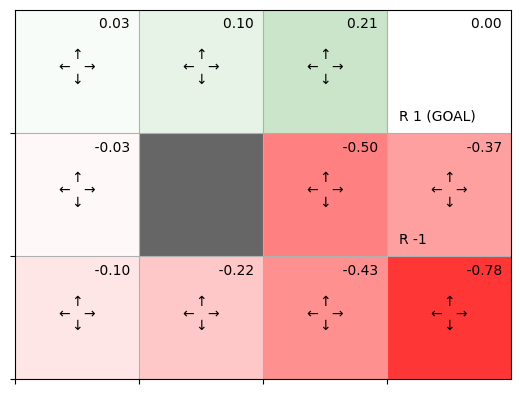

In [9]:
# 무작위 정책의 정책평가
env = GridWorld()
gamma = 0.9
pi = defaultdict(lambda: {0 : 0.25, 1 : 0.25, 2 : 0.25, 3 : 0.25})
V = defaultdict(lambda: 0)

V = policy_eval(pi, V, env, gamma)
env.render_v(V, pi)

무작위 정책에 대한 평가가 이루어 진 뒤 정책을 개선하는 과정을 거친다.  
기존 가치평가 함수에 argmax가 추가되는 벨만방정식을 구현하는데 정책을 딕셔너리 형태로 구현하여 numpy argmax을 적용하기 어렵다.  
딕셔너리에 사용할 argmax함수를 커스텀하게 제작한다.

In [10]:
def argmax(x):
    max_value = max(x.values())
    max_key = 0
    for key, val in x.items():
        if val == max_value:
            max_key = key
    return max_key

In [11]:
# 정책 탐욕화 함수
def greedy_policy(X, env, gamma):
    pi = {}

    for state in env.states():
        action_values = {}

        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values[action] = value
        
        max_action = argmax(action_values) # 액션 딕셔너리 중 가치가 가장 높은 액션 선택
        action_probs = {0:0, 1:0, 2:0, 3:0} # 확률값 초기화
        action_probs[max_action] = 1.0
        pi[state] = action_probs
    
    return pi

In [12]:
# 정책 평가를 진행하면서 탐욕화 과정 추가
def policy_iter(env, gamma, threshold=0.001, is_render=False):
    pi = defaultdict(lambda : {0:0.25, 1:0.25, 2:0.25, 3:0.24}) # 무작위 정책으로 초기화
    V = defaultdict(lambda : 0)

    while True:
        V = policy_eval(pi, V, env, gamma, threshold) # 정책 평가 한사이클 수행
        new_pi = greedy_policy(V, env, gamma) # 정책 개선

        if is_render:
            env.render_v(V, pi)

        if new_pi == pi: # 갱신이 될때까지 수행
            break
        pi = new_pi

    return pi

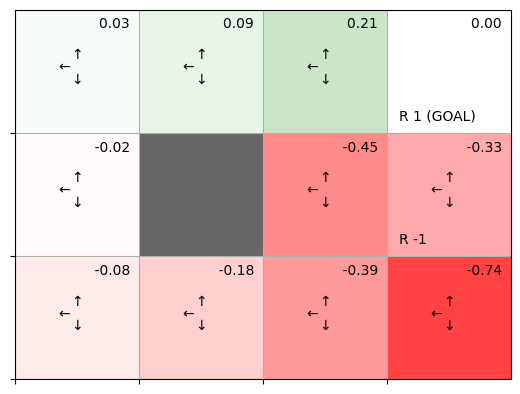

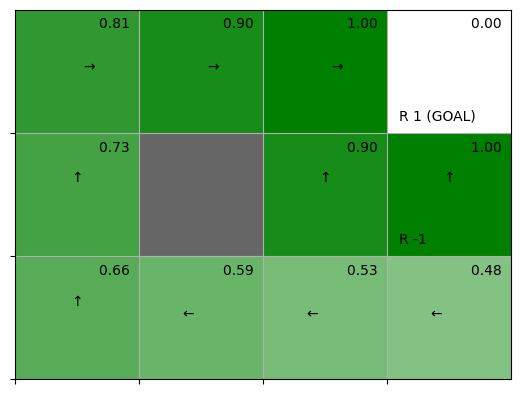

In [14]:
env = GridWorld()
gamma = 0.9
pi = policy_iter(env, gamma, is_render=True)

앞서 수행한 과정은 정책평가를 통해 벨만최적방정식을 구현하는 방법이였지만 이를 조금 더 단순화 시키는 방법으로 가치 반복법을 수행한다.  
도출과정은 링크 참고

In [46]:
# 가치함수 한번 갱신하는 함수
def value_iter_onestep(V, env, gamma):
    for state in env.states():
        if state == env.goal_state:
            V[state] = 0
            continue

        action_values = []
        for action in env.actions():
            next_state = env.next_state(state, action)
            r = env.reward(state, action, next_state)
            value = r + gamma * V[next_state]
            action_values.append(value)
        
        V[state] = max(action_values)

    return V

In [24]:
def value_iter(V, env, gamma, threshold=0.001, is_render=True):
    while True:
        if is_render:
            env.render_v(V)

        old_V = V.copy()
        V = value_iter_onestep(V, env, gamma)

        delta = 0
        for state in V.keys():
            t = abs(V[state] - old_V[state])
            if delta < t:
                delta = t
        
        if delta < threshold:
            break
    
    return V

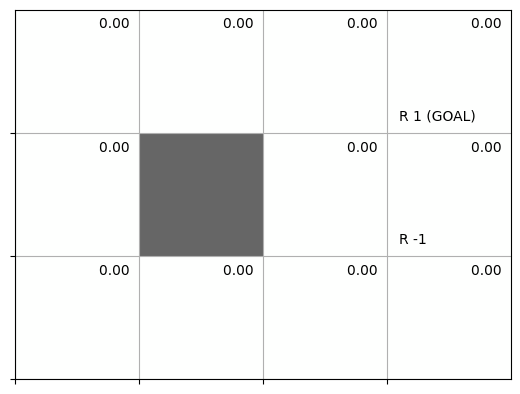

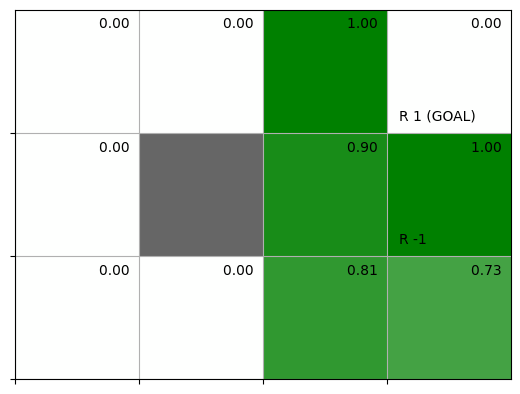

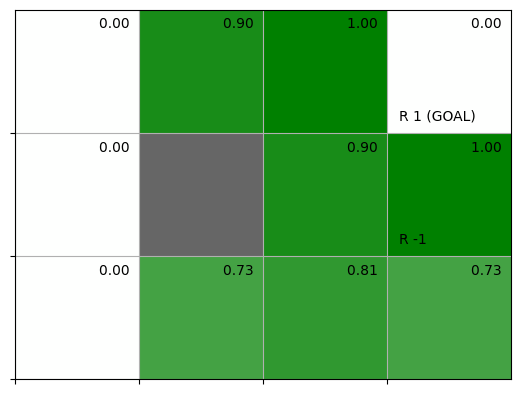

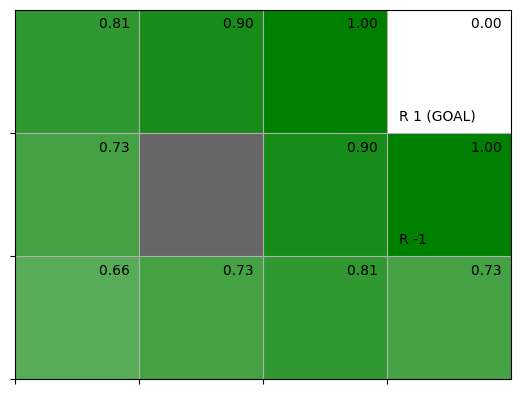

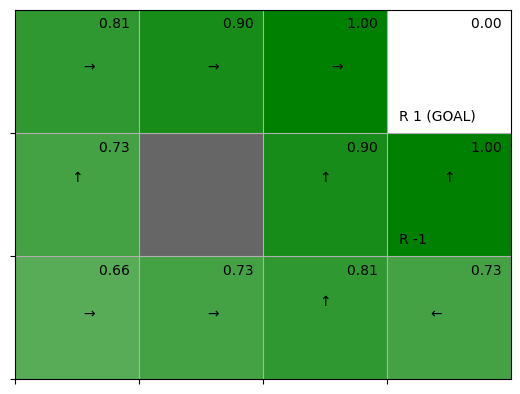

In [47]:
env = GridWorld()
V = defaultdict(lambda : 0)
gamma = 0.9
V = value_iter(V, env, gamma)
pi = greedy_policy(V, env, gamma)
env.render_v(V, pi)